# Some Analysis on an Online Retail Dataset

dataset source:

https://archive.ics.uci.edu/ml/datasets/online+retail


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# set your own local path to data or download from the source
data_path = "data.csv"

df = pd.read_csv(data_path, encoding= 'unicode_escape')

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
print(f'dataset shape before cleaning is {df.shape}')

dataset shape before cleaning is (541909, 8)


In [3]:
# Simple Data cleaning and formatting

df.dropna(inplace=True)
df.drop_duplicates(inplace = True)
df["InvoiceDate"] = pd.to_datetime(df.InvoiceDate, cache=True)
df["CustomerID"] = df["CustomerID"].astype(int)

print(f'dataset shape after cleaning is {df.shape}')

dataset shape after cleaning is (401604, 8)


In [4]:
df['amount_spent'] = df['Quantity'] * df['UnitPrice']

## Part 1: Exploratory Data Analysis (EDA)

<AxesSubplot:xlabel='CustomerID'>

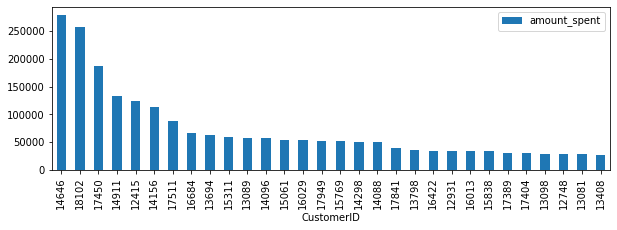

In [5]:
# Q = who has bought most?

money_spent = df.groupby(by=['CustomerID','Country'], as_index=False)['amount_spent'].sum()
money_spent.sort_values(by='amount_spent', ascending=False, inplace=True)
money_spent.reset_index(inplace=True, drop=True)

money_spent.iloc[:30, :].plot(kind='bar', x='CustomerID', y='amount_spent', figsize=(10,3))


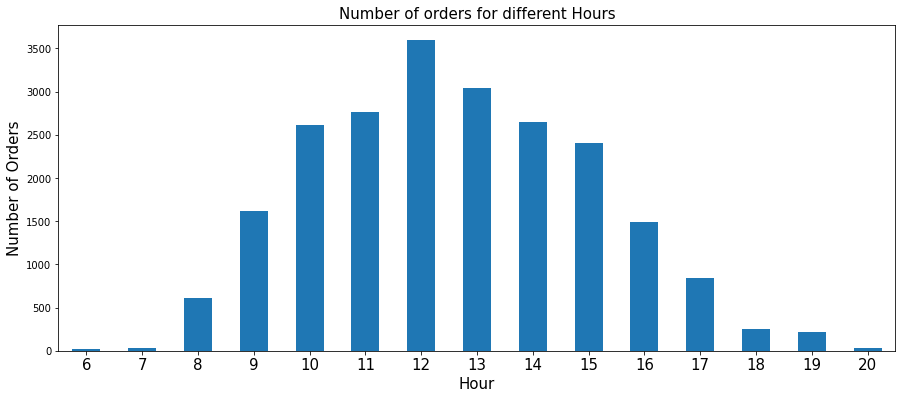

In [6]:
# Q: When they buy?

# source: https://www.kaggle.com/admond1994/e-commerce-data-eda

df['hour'] = df.InvoiceDate.dt.hour

ax = df.groupby('InvoiceNo')['hour'].unique().value_counts().iloc[:-1].sort_index().plot(kind='bar',figsize=(15,6))
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Hours',fontsize=15)
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()

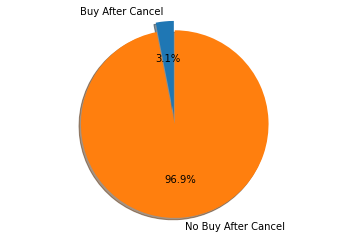

In [7]:
# Q: Will cancelers buy again?

buy_df = df[df.amount_spent > 0]
cancel_df = df[df.amount_spent < 0]

aggregation_type_buy = {'Quantity':'sum', 'InvoiceDate':'first', 'amount_spent': 'sum'}
df_grouped_by_cutomer_buy = buy_df.groupby(by=['CustomerID'], as_index=False).agg(aggregation_type_buy)
df_grouped_by_cutomer_buy.reset_index(drop=True, inplace=True)

aggregation_type_cancel = {'Quantity':'sum', 'InvoiceDate':'last', 'amount_spent': 'sum'}
df_grouped_by_cutomer_cancel = cancel_df.groupby(by=['CustomerID'], as_index=False).agg(aggregation_type_cancel)
df_grouped_by_cutomer_cancel.reset_index(drop=True, inplace=True)

merged_dates = pd.merge(df_grouped_by_cutomer_buy[['CustomerID', 'InvoiceDate']], df_grouped_by_cutomer_cancel[['CustomerID', 'InvoiceDate']], on='CustomerID')
merged_dates['buy_again'] = (merged_dates.InvoiceDate_x > merged_dates.InvoiceDate_y).astype(int)

labels = 'Buy After Cancel', 'No Buy After Cancel',
sizes = [merged_dates.buy_again.mean(), 1 - merged_dates.buy_again.mean()]
explode = (0.1, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


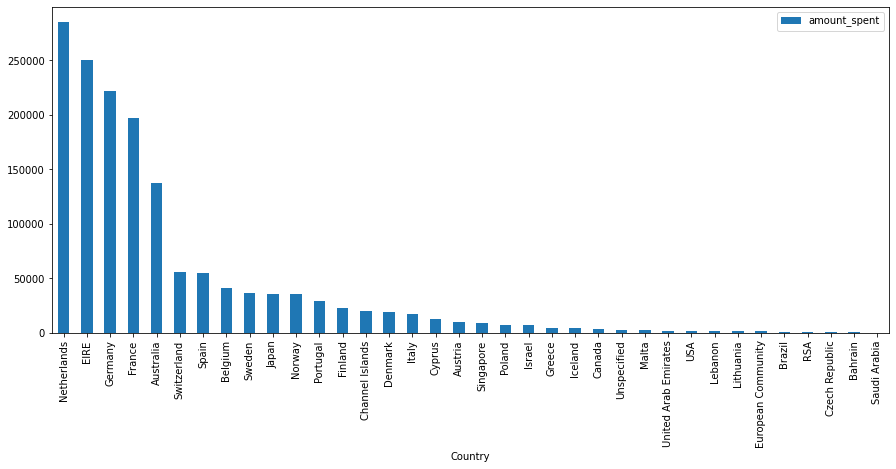

In [8]:
# Q: Which countries buy most?

df_grouped_by_country = df.groupby(by=['Country'], as_index=False)['amount_spent'].sum()
df_grouped_by_country.drop(df_grouped_by_country.loc[df_grouped_by_country['Country']=='United Kingdom'].index, inplace=True)
df_grouped_by_country.sort_values(by='amount_spent', ascending=False, inplace=True)
df_grouped_by_country.reset_index(drop=True, inplace=True)

df_grouped_by_country.plot(kind='bar', x='Country', figsize=(15,6))
ax.set_xlabel('Country',fontsize=15)
ax.set_ylabel('Value of Orders',fontsize=15)
ax.set_title('Value of orders for different Countries',fontsize=15)
plt.show()

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

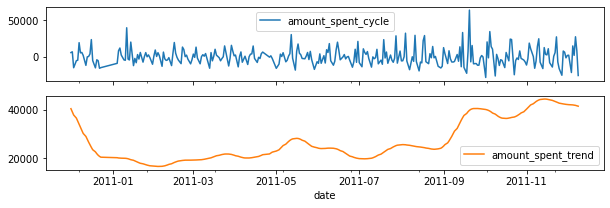

In [9]:
# Q: Is there any trend for sales time-series?

from statsmodels.tsa.filters.hp_filter import hpfilter

df['date'] = df.InvoiceDate.dt.date

df_grouped_by_date = df.groupby(by=['date'], as_index=False)['amount_spent'].sum()

amount_spent_filtered = hpfilter(df_grouped_by_date.amount_spent, lamb=1000)

df_grouped_by_date['amount_spent_cycle'] = amount_spent_filtered[0]
df_grouped_by_date['amount_spent_trend'] = amount_spent_filtered[1]

df_grouped_by_date.plot(x='date', y=['amount_spent_cycle', 'amount_spent_trend'], subplots=True, figsize=(10,3))

<AxesSubplot:>

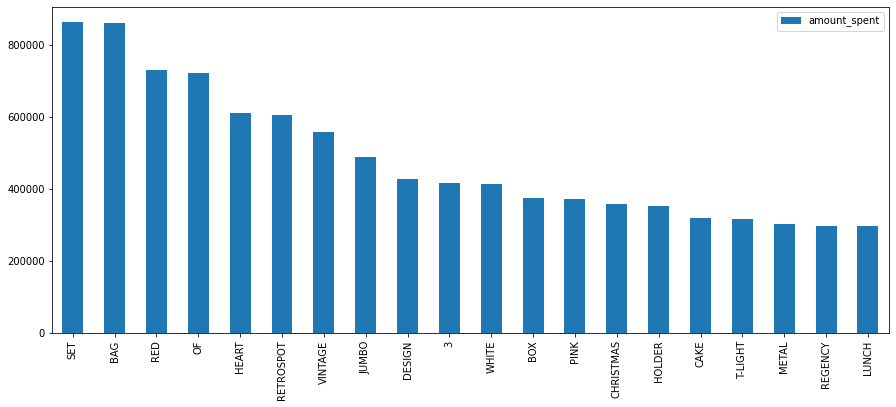

In [10]:
# Which keywords are selling more?

df['Description_tokenized'] = df.Description.apply(lambda x: x.split())

amount_spent_by_keyword = {}

for i, x in df.iterrows():
    for keyword in x.Description_tokenized:
        if keyword in amount_spent_by_keyword:
            amount_spent_by_keyword[keyword] += x.amount_spent
        else:
            amount_spent_by_keyword[keyword] = x.amount_spent

amount_spent_by_keyword_df = pd.DataFrame.from_dict(amount_spent_by_keyword, orient='index')

amount_spent_by_keyword_df.columns = ['amount_spent']
amount_spent_by_keyword_df.sort_values(by='amount_spent', ascending=False, inplace=True)

amount_spent_by_keyword_df.iloc[:20,:].plot(kind='bar', figsize=(15,6))